In [2]:
import math
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest

In [3]:
columns = ["timestamp", "value"]
df = pd.read_csv("data/art_daily_jumpsup.csv", usecols=columns)
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%d %H:%M:%S").values.astype("float64")

In [3]:
def euclidean_distance(dot, centroid):
  return math.sqrt((centroid[0]-dot[0])**2 + (centroid[1]-dot[1])**2)

def nearest_centroid(dot, centroids):
  distances = []
  for centroid in centroids:
    distances.append(euclidean_distance(dot, centroid))
  return distances.index(min(distances))

def new_centroid(cluster_members):
  mean_date = 0
  mean_value = 0
  for i in range(0, len(cluster_members)):
    mean_date += cluster_members[i][0]
    mean_value += cluster_members[i][1]
  return [mean_date/len(cluster_members), mean_value/len(cluster_members)]

In [4]:
def kmeans_clustering(df, k, max_iterations):
  iteration = 0
  date = df['timestamp'].values.tolist()
  value = df['value'].values.tolist()
  #date = [1,2,1,5,5,6]
  #value = [1,1,2,4,5,5]
  centroids = []
  new_centroids = []
  clusterized_values = {}

  for i in range(0, k):
    random_number = random.randint(0, len(date)-1)
    centroids.append([date.pop(random_number), value.pop(random_number)])

  while sorted(centroids) != sorted(new_centroids) and iteration < max_iterations:
    if iteration != 0:
      centroids = new_centroids
      new_centroids = []
      clusterized_values = {}
    for i in range(0, len(date)):
      cluster = nearest_centroid([date[i], value[i]], centroids)
      if cluster in clusterized_values.keys():
        clusterized_values[cluster].append([date[i], value[i]])
      else:
        clusterized_values[cluster] = [[date[i], value[i]]]
    for i in range(0, k):
      new_centroids.append(new_centroid(clusterized_values[i]))
    if iteration == 0:
      for centroid in centroids:
        date.append(centroid[0])
        value.append(centroid[1])
    iteration += 1

  return clusterized_values

In [5]:
a = kmeans_clustering(df, 14, 300)

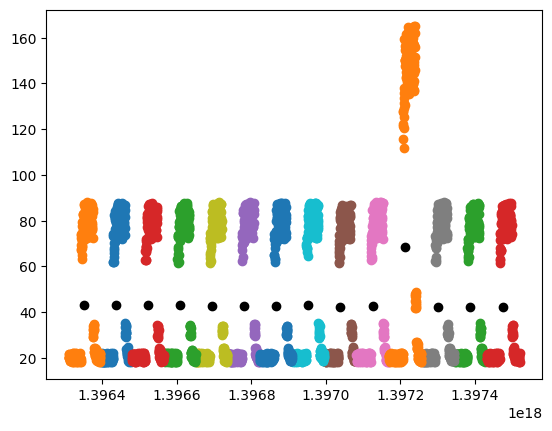

In [6]:
def plot_cluster(cluster):
  centroid = new_centroid(cluster)
  x = []
  y = []
  for i in cluster:
    x.append(i[0])
    y.append(i[1])
  plt.scatter(x, y)
  plt.scatter(centroid[0], centroid[1], c="black")

for i in range(0, len(a)):
  if (i % 2) == 0:
    plot_cluster(a.get(i))
  else:
    plot_cluster(a.get(i))

plt.show()

In [7]:
def standart_deviation(cluster, centroid):
  distances = []
  for point in cluster:
    distances.append(euclidean_distance(point, centroid))
  mean = sum(distances)/len(distances)
  std_start = 0
  for distance in distances:
    std_start += (distance - mean)**2
  return [mean, distances, math.sqrt(std_start/(len(distances)-1))]

def find_distance_anomaly(mean, distances, std, cluster):
  anomalys = []
  for distance in distances:
    if distance > (mean + (3 * std)):
      anomalys.append(cluster[distances.index(distance)])
    elif (mean - (3 * std)) > 0 and distance < (mean - (3 * std)):
      anomalys.append(cluster[distances.index(distance)])
  return anomalys

def anomaly_detection(df, clusterized_values):
  anomalys = []
  threshold = int(0.01 * len(df))
  for cluster in clusterized_values.values():
    if len(cluster) < threshold:
      anomalys.append(cluster)
    else:
      mean, distances, std = standart_deviation(cluster, new_centroid(cluster))
      anomaly_points = find_distance_anomaly(mean, distances, std, cluster)
      anomalys.extend(anomaly_points)
  return anomalys

print(anomaly_detection(df, a))

[]


[3001, 3085, 3093, 3095]


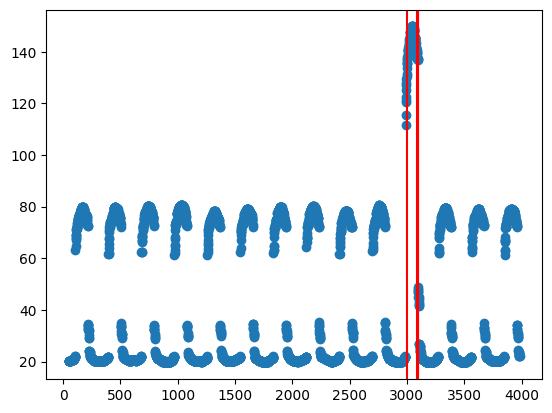

In [4]:
columns = ["timestamp", "value"]
df = pd.read_csv("data/art_daily_jumpsup.csv", usecols=columns)

def is_anomaly(sliding_window, threshold, y, t):
  med = np.median(sliding_window)
  lower = med - threshold
  upper = med + threshold
  if(y >= lower and y <= upper):
    return False
  return True

def anomaly_detection(data, window_size, threshold):
  start_index, end_index, window_lower, window_upper = 0, 0, 0, 0
  anomalies = []
  medians = []
  ts = []
  if window_size % 2:
    start_index = math.floor(window_size/2)
    end_index = len(data) - start_index
    window_lower = start_index
    window_upper = start_index
  else:
    start_index = math.floor(window_size/2) - 1
    end_index = len(data) - start_index + 1
    window_lower = start_index
    window_upper = start_index + 1
  t = start_index
  while(t < end_index):
    sliding_window = data[t-window_lower:t+window_upper]
    med = np.median(sliding_window)
    medians.append(med)
    ts.append(t)
    anomaly = is_anomaly(sliding_window, threshold, data[t], t)
    if anomaly == True:
      anomalies.append(t)
    t +=1
  plt.scatter(ts, medians)
  for i in anomalies:
    plt.axvline(x = i, color = 'r', label = 'axvline - full height')
  return anomalies
print( anomaly_detection(df["value"].values, 100, 20))

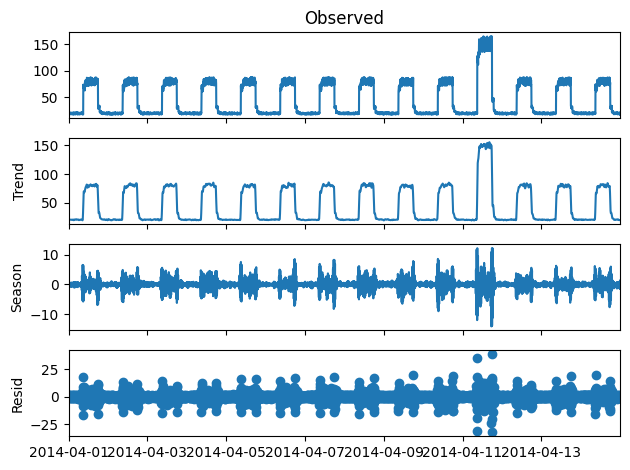

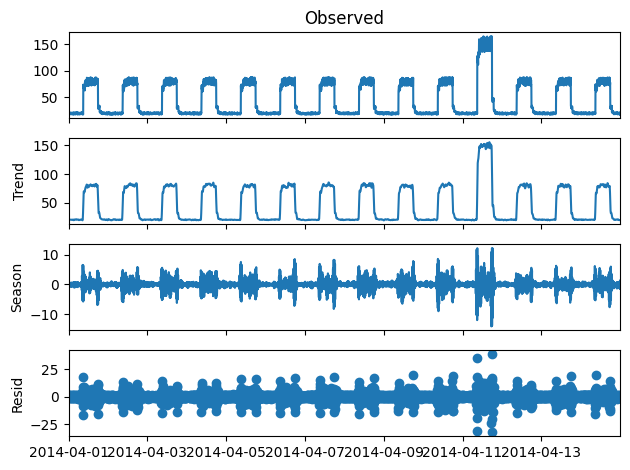

In [14]:
data = pd.read_csv("data/art_daily_jumpsup.csv", index_col=0, parse_dates=True)
stl_result = STL(data, period=5).fit()
stl_result.plot()

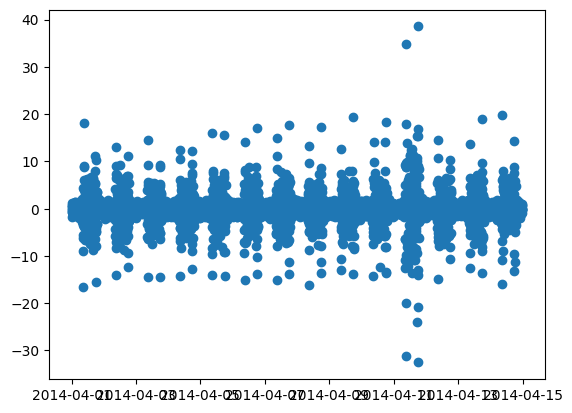

In [15]:
x = stl_result.resid.index
y = stl_result.resid.values

plt.scatter(x, y)

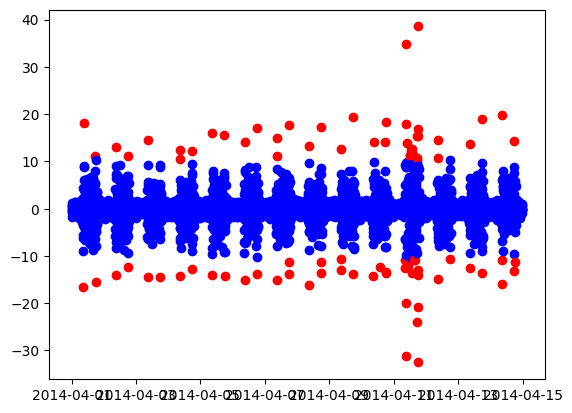

In [16]:
resid_mu = stl_result.resid.mean()
resid_dev = stl_result.resid.std()
lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev
for i in range(len(y)):
  if y[i] <lower or y[i] > upper:
    plt.scatter(x[i], y[i], c="red")
  else:
    plt.scatter(x[i], y[i], c="blue")


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


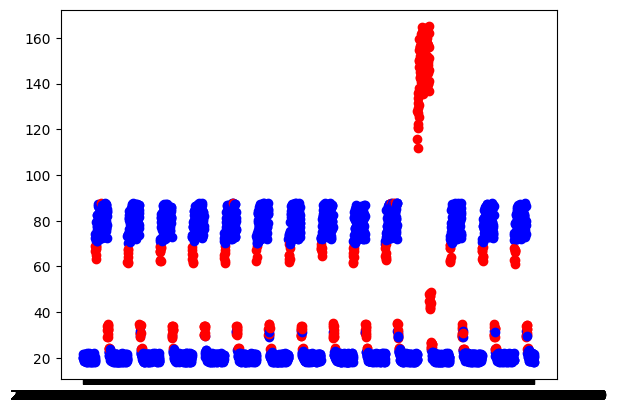

In [18]:
df = pd.read_csv("data/art_daily_jumpsup.csv", usecols=columns)

model=IsolationForest(n_estimators=14, max_samples='auto',
                      contamination=float(0.1),max_features=1.0)
model.fit(df[["value"]])
df['anomaly']=model.predict(df[["value"]])
for i in range(len(df)):
  if df['anomaly'][i] == -1:
    plt.scatter(df['timestamp'][i], df["value"][i], c="red")
  else:
    plt.scatter(df['timestamp'][i], df["value"][i], c="blue")